Text(0.5, 0, 'Strain')

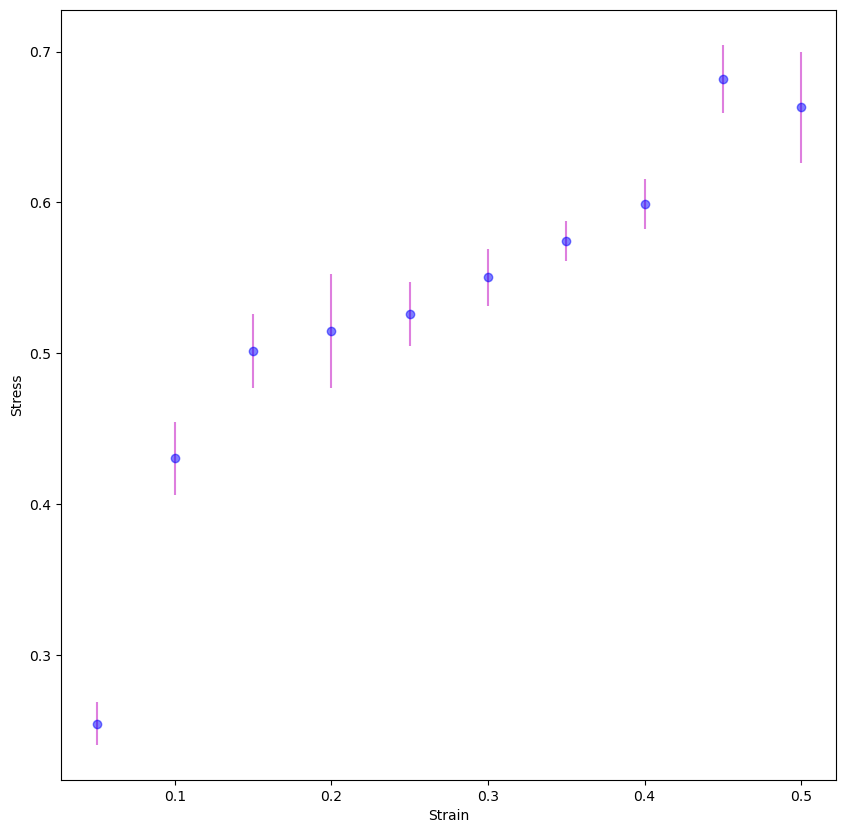

In [1]:
# Display Data
import numpy as np
import pandas as pd

# Read the csv file using pandas
df = pd.read_csv('MData.csv')

# Convert the dataframe to a 3D numpy array
array_3d = np.array([df.values.tolist()])
strain = array_3d[0,:,0]
stress = array_3d[0,:,1]
sd = array_3d[0,:,2]

import matplotlib.pyplot as plt
#Plot Strain-Stress Scatter Graph.
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m', alpha=0.5)
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

In [2]:
strain

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [3]:
df

,Strain,mean,sd
0,0.05,0.254823,0.014003
1,0.10,0.430447,0.024344
2,0.15,0.501413,0.024461
3,0.20,0.514713,0.037729
4,0.25,0.526133,0.021151
5,0.30,0.550443,0.018979
6,0.35,0.574680,0.013103
7,0.40,0.598780,0.016494
8,0.45,0.681987,0.022528
9,0.50,0.662970,0.036526


/Users/wangchenjie/opt/anaconda3/envs/MDM/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 0, 'Strain')

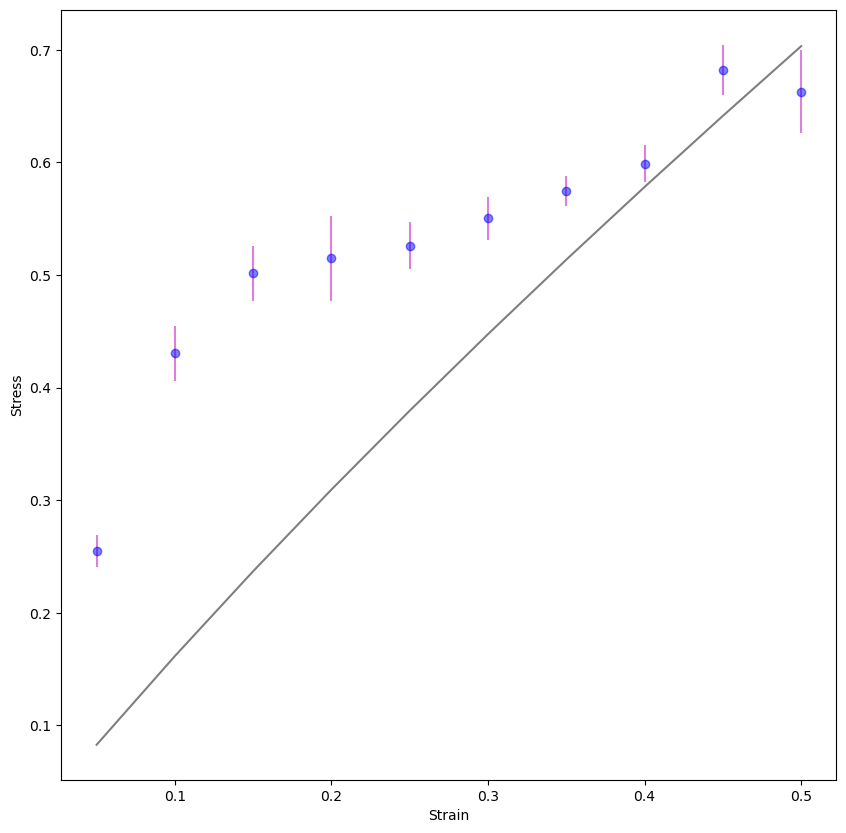

In [4]:
from pylab import * 
import scipy.optimize

def uniaxial_stress(model, trueStrainVec, params):
 """Compressible uniaxial loading. Returns true stress. 
 N: "ture" means add a exp() term on the strain.
 N: model() calls the hyperelastic model, defined below."""
 stress = zeros(len(trueStrainVec))
 for i in range(len(trueStrainVec)):
  lam1 = 1+trueStrainVec[i] #N: convert strain to stretch
  #print(lam1)
  x0 = 1.1/sqrt(lam1)
  #print(x0)

  calcS22Abs = lambda x: abs( model(lam1,x,x,params)[1,1] )
  #N:The calcS22Abs function is a lambda function that takes 
  #one argument x and returns the absolute value of 
  #the element S22 of the stress tensor, computed by the 
  #model function for a given stretch tensor [lam1,x,x] and params.

  #N:[1,1] is used to access the element in the second row 
  #and second column of the stress tensor (S22)

  # search for transverse stretch that gives S22=0
  lam2 = scipy.optimize.fmin(calcS22Abs, x0,
                 xtol=1e-9, ftol=1e-9, disp=False)
  #N: it uses "fmin" to find the unkown two strains, starting
  #the loop with J=1 (x0=1/sqrt(lam1)),instead of defining a 
  #new variable J.

  stress[i] = model(lam1,lam2,lam2, params)[0,0]
  #N:stores the element S11 in the stress array at 
  #the current strain index i

 return stress
 
def NH_3D(stretch1,stretch2,stretch3,param):
 """Neo-Hookean. 3D loading specified by stretches.
 param[0]=mu, param[1]=kappa"""
 stretch2 = stretch2[0]
 stretch3 = stretch3[0]
 #print(stretch2)
 F = array([ [stretch1,0,0],[0,stretch2,0],[0,0,stretch3] ])
 #print(F)
 #print(F.shape)
 J = det(F)
 Fstar = J**(-1/3) * F
 bstar = dot(Fstar, Fstar.T)
 dev_bstar = bstar - trace(bstar)/3 * eye(3)
 return param[0]/J * dev_bstar + param[1]*(J-1) * eye(3)
initial_values = [0.7,1]
stress_initial_guess = uniaxial_stress(NH_3D, strain, initial_values) 
#mu=param[0],k=mu=param[1]

# Fit the data with deterministic model
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m', alpha=0.5)
ax1.plot(strain, stress_initial_guess, 'k', alpha=0.5)
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

**Statistic Model** 

In [5]:
def likelihood(param, strain, stress, sd):
    stress_e = uniaxial_stress(NH_3D, strain, param)
    l=-np.log(sd * np.sqrt(2* np.pi))-((stress-stress_e)**2) / (2*sd**2)
    log_likelihood = np.sum(l)
    #print(l)
    return log_likelihood

The prior distribution for the model parameters is simply the normal distribution we used to generate the values of E. 

N: The proposal_sd defines the "transition model" between current guess and new guess.

We can then define the MCMC algorithm using the Metropolis-Hastings algorithm:

In [6]:
def metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd):
    n_params = len(initial_values)
    samples = np.zeros((n_iterations, n_params))
    current_values = initial_values
    accepted = np.zeros(n_iterations)
    rejected = np.zeros(n_iterations)
    for i in range(n_iterations):
        # Propose new values
        proposal = current_values + np.random.normal(0, proposal_sds, n_params)
        # Calculate the acceptance ratio
        ratio = np.exp(likelihood(proposal, strain, stress, sd) - likelihood(current_values, strain, stress, sd))
        #print(ratio)
        acceptance_ratio = min(1, ratio)
        # Decide whether to accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
            current_values = proposal
            accepted[i] = 1
        else:
            rejected[i] = 1
        samples[i] = current_values
    return samples, accepted, rejected

In [7]:
n_iterations = 5000
proposal_sds = [5, 5]

# Run MCMC algorithm
samples, accepted, rejected = metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd)

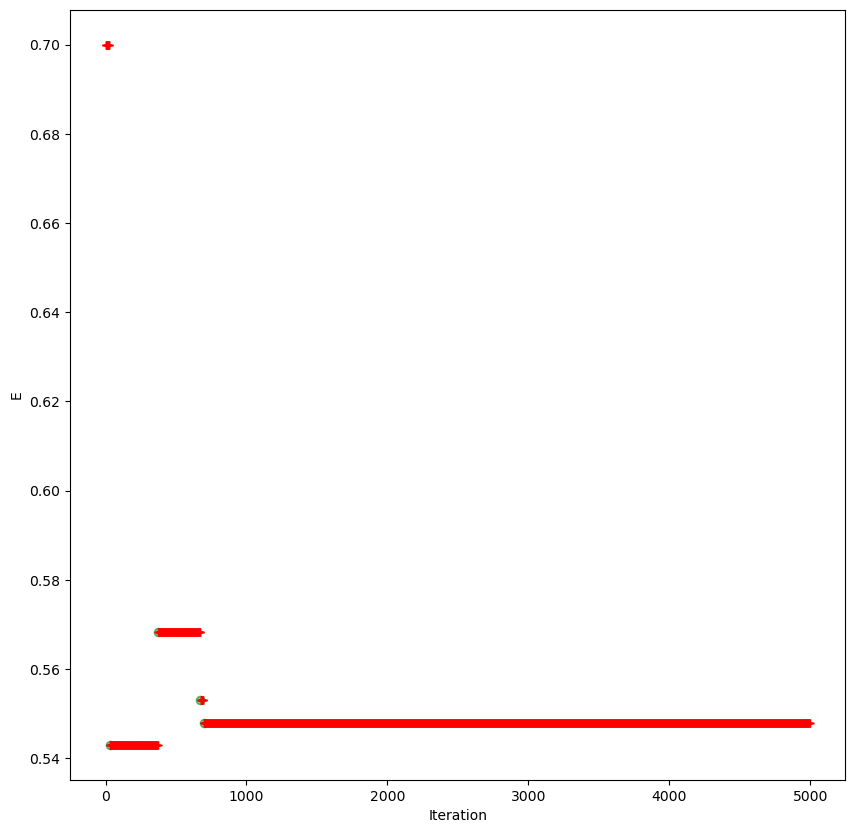

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
#ax.plot(np.arange(n_iterations), samples, alpha=0.5)
ax.plot(np.arange(n_iterations)[accepted==1], samples[accepted==1][:,0], 'go', alpha=0.5)
ax.plot(np.arange(n_iterations)[rejected==1], samples[rejected==1][:,0], 'r+', alpha=0.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('E')
plt.show()

[ 0.5477883  21.63098095]


Text(0.5, 0, 'Strain')

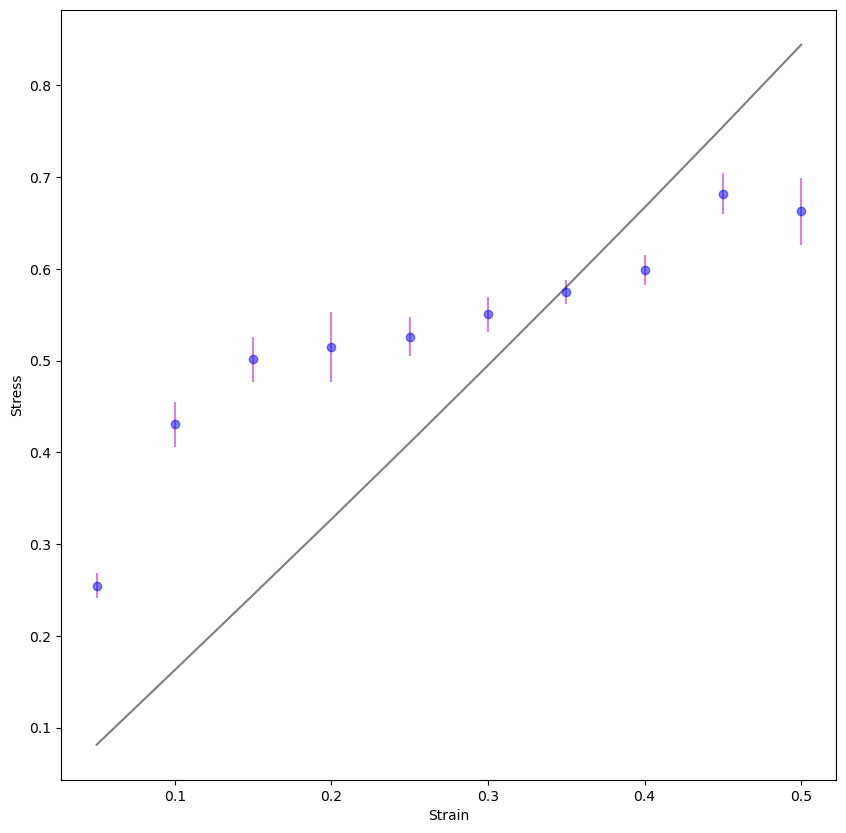

In [9]:
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
# Plot the trace of the parameters
param = samples[accepted==1][-1]
print(param)
y2 =  uniaxial_stress(NH_3D, strain, param)
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m', alpha=0.5)
ax1.plot(strain, y2, 'k-', alpha=0.5)
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')